# Model Selection and Implementation - Wheat Pricing Data
## Time Series and Machine Learning Final Project Code
## Will Bartlett and David Whitmer


In [2]:
#import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ar_select_order
import itertools
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [3]:
#Import Dataset
df = pd.read_csv('../Final Data/Final_Data.csv')

## 1 Time Series Model Tests
### 1.1 AR Model

In [5]:
#Find optimal lag to test
best_model = ar_select_order(df['wheat_price'], maxlag=25, ic='aic', old_names=False)
print(f"Optimal lag order selected for Monthly return : {best_model.ar_lags}")

Optimal lag order selected for Monthly return : [1, 2, 3, 4, 5, 6, 7, 8]


In [6]:
#AR(1) Model
ar_1 = AutoReg(df['wheat_price'], lags = 1).fit()
ar_1_aic = ar_1.aic
print('AR(1) Results: \n',ar_1.summary())

AR(1) Results: 
                             AutoReg Model Results                             
Dep. Variable:            wheat_price   No. Observations:                  421
Model:                     AutoReg(1)   Log Likelihood                -390.448
Method:               Conditional MLE   S.D. of innovations              0.613
Date:                Sat, 26 Apr 2025   AIC                            786.896
Time:                        13:46:52   BIC                            799.017
Sample:                             1   HQIC                           791.687
                                  421                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2741      0.083      3.308      0.001       0.112       0.436
wheat_price.L1     0.9438      0.016     58.648      0.000       0.912       0.975
                   

In [7]:
#AR(2) Model
ar_2 = AutoReg(df['wheat_price'], lags = 2).fit()
ar_2_aic = ar_2.aic
print('\nAR(2) Results: \n',ar_2.summary())


AR(2) Results: 
                             AutoReg Model Results                             
Dep. Variable:            wheat_price   No. Observations:                  421
Model:                     AutoReg(2)   Log Likelihood                -374.137
Method:               Conditional MLE   S.D. of innovations              0.591
Date:                Sat, 26 Apr 2025   AIC                            756.273
Time:                        13:46:52   BIC                            772.425
Sample:                             2   HQIC                           762.658
                                  421                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2043      0.081      2.526      0.012       0.046       0.363
wheat_price.L1     0.6891      0.047     14.650      0.000       0.597       0.781
wheat_price.L2    

### 1.2 ARIMA Model

In [9]:
#Find best params for ARIMA model
p = range(0, 3)  # AR order
d = range(0, 2)  # Differencing
q = range(0, 3)  # MA order
pdq = list(itertools.product(p, d, q))

#use aic for best model, set up saves
best_aic = float('inf')
best_pdq = None

for param in pdq:
    try:
        model = ARIMA(df['wheat_price'], order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
    except:
        continue

best_arima_aic = best_aic

print(f"Best ARIMA order based on AIC: {best_pdq}")

Best ARIMA order based on AIC: (0, 1, 1)


In [10]:
#Test best model ARIMA(0,1,1)
arima_011 = ARIMA(df['wheat_price'], order=best_pdq).fit()
print('ARIMA(0,1,1) Results: \n',arima_011.summary())

ARIMA(0,1,1) Results: 
                                SARIMAX Results                                
Dep. Variable:            wheat_price   No. Observations:                  421
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -374.330
Date:                Sat, 26 Apr 2025   AIC                            752.660
Time:                        13:46:53   BIC                            760.741
Sample:                             0   HQIC                           755.854
                                - 421                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3533      0.027    -13.308      0.000      -0.405      -0.301
sigma2         0.3480      0.008     44.367      0.000       0.333       0.363
Ljung-Box (L1) (Q):         

### 1.4 ARIMAX Model

In [12]:
#Save exogenous data separately
exog_data = df.copy().drop(columns = ['wheat_price','date'])

#standardize exogenous features
exog_data = (exog_data - exog_data.mean()) / exog_data.std()

In [13]:
#Find best params for ARIMAX model
p = range(0, 3)  #AR order
d = range(0, 2)  #differencing options
q = range(0, 3)  #MA order
pdq = list(itertools.product(p, d, q))

#find best model params by aic
best_arimax_aic = float('inf')
best_arimax_params = None
for param in pdq:
    try:
        model = SARIMAX(df['wheat_price'], 
                        exog=exog_data,
                        order=param, 
                        seasonal_order=(0, 0, 0, 0))  #don't add seasonality
        results = model.fit(disp=False)
        if results.aic < best_arimax_aic:
            best_arimax_aic = results.aic
            best_arimax_params = param
    except:
        continue

print(f"Best ARIMAX model order based on AIC: {best_arimax_params}; AIC = {best_arimax_aic}")

Best ARIMAX model order based on AIC: (2, 1, 1); AIC = 722.5592045787773


In [14]:
#Test ARIMAX(2,1,1)
arimax_101 = SARIMAX(df['wheat_price'], 
                     exog=exog_data,
                     order=best_arimax_params, 
                     seasonal_order=(0, 0, 0, 0)).fit(disp=False)
print('ARIMAX(2,1,1) Results: \n',arimax_101.summary())

ARIMAX(2,1,1) Results: 
                                SARIMAX Results                                
Dep. Variable:            wheat_price   No. Observations:                  421
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -348.280
Date:                Sat, 26 Apr 2025   AIC                            722.559
Time:                        13:46:58   BIC                            775.083
Sample:                             0   HQIC                           743.319
                                - 421                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
fertilizer_idx        0.4169      0.236      1.766      0.077      -0.046       0.880
avg_temp             -0.1146      0.067     -1.705      0.088      -0.246       0.017

### 1.4 SARIMAX Model

#### 1.4.1 ACF Plot For Seasonality Test

<Figure size 1200x1000 with 0 Axes>

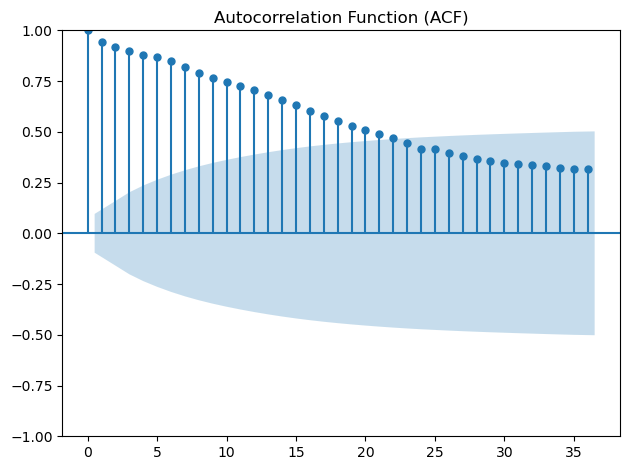

In [17]:
#Plot ACF
plt.figure(figsize=(12, 10))
plot_acf(df['wheat_price'], lags=36 ) 
plt.title('Autocorrelation Function (ACF)')
plt.tight_layout()
plt.show()

#### 1.4.2 SARIMAX Model Implementation

In [19]:
#Find best seasonal params for SARIMAX
P = range(0, 2)  #seasonal AR order
D = range(0, 2)  #seasonal differencing
Q = range(0, 2)  #seasonal MA order
s = 12  #yearly seasonality

#Create all combinations of seasonal parameters
seasonal_pdq = list(itertools.product(P, D, Q, [s]))

# Find best SARIMAX model with both ARIMA and seasonal components
best_sarimax_aic = float('inf')
best_seasonal_params = None

# Grid search over seasonal parameters
for seasonal_param in seasonal_pdq:
    try:
        model = SARIMAX(df['wheat_price'], 
                       exog=exog_data,
                       order=best_arimax_params, #use best arimax params
                       seasonal_order=seasonal_param,)
        
        results = model.fit(disp=False, maxiter=100)
        current_aic = results.aic
        
        if current_aic < best_sarimax_aic:
            best_sarimax_aic = current_aic
            best_seasonal_params = seasonal_param
            sarimax_results = results
    except Exception as e:
        
        continue

print(f"\nBest SARIMAX model: SARIMAX{best_arimax_params}x{best_seasonal_params} with AIC: {best_sarimax_aic:}")


Best SARIMAX model: SARIMAX(2, 1, 1)x(1, 0, 1, 12) with AIC: 713.4062354399728


In [20]:
#Test SARIMAX(2,1,1)x(0,0,1,12)
print(sarimax_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        wheat_price   No. Observations:                  421
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -341.703
Date:                            Sat, 26 Apr 2025   AIC                            713.406
Time:                                    13:47:30   BIC                            774.010
Sample:                                         0   HQIC                           737.360
                                            - 421                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
fertilizer_idx        0.4238      0.252      1.683      0.092      -0.070       0.918
avg_temp      

### 1.5 Next Year Forecasting

#### 1.5.1 Predict Future Exogenous Variables Using VAR

In [23]:
#VAR model
var_model = VAR(exog_data)
lag_order_results = var_model.select_order(maxlags=10)
print(lag_order_results.summary())
optimal_lag = lag_order_results.aic
print(f'Optimal Lag: {optimal_lag}')

# Fit the model with the optimal lag
var_fitted = var_model.fit(maxlags=optimal_lag)  # Use the optimal lag found

# Forecast future values
future_exog = var_fitted.forecast(y=exog_data.values[-optimal_lag:], steps=12)
future_exog = pd.DataFrame(future_exog, columns=exog_data.columns)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -13.55      -13.47   1.298e-06      -13.52
1       -42.29      -41.41   4.322e-19      -41.94
2       -45.21     -43.54*   2.315e-20      -44.55
3       -45.68      -43.22   1.449e-20      -44.71
4       -46.01      -42.75   1.052e-20     -44.72*
5      -46.04*      -41.99  1.018e-20*      -44.44
6       -46.03      -41.19   1.034e-20      -44.12
7       -45.92      -40.29   1.168e-20      -43.69
8       -45.84      -39.41   1.282e-20      -43.30
9       -45.81      -38.59   1.343e-20      -42.95
10      -45.94      -37.93   1.200e-20      -42.77
--------------------------------------------------
Optimal Lag: 5


#### 1.5.2 Forecast For Each Model

In [25]:
#AR(1) Forecasting
ar_1_forecast = ar_1.predict(start=len(df), end=len(df) + 11)
#AR(2) forecasting
ar_2_forecast = ar_2.predict(start=len(df), end=len(df) + 11)
#ARIMA forecasting
arima_011_forecast = arima_011.forecast(steps=12)
#ARIMAX forecasting
arimax_101_forecast = arimax_101.forecast(steps=12, exog=future_exog)
#SARIMAX forecasting
sarimax_101_forecast = sarimax_results.forecast(steps=12, exog=future_exog)

### 1.6 Time Series Model Comparisons

In [27]:
#Compare forecasts using df
forecast_df = pd.DataFrame({
    'Month': ['Nov 2024', 'Dec 2024', 'Jan 2025', 'Feb 2025', 'Mar 2025', 'Apr 2025', 'May 2025',
             'Jun 2025', 'Jul 2025','Aug 2025', 'Sep 2025', 'Oct 2025'],
    'AR(1)': ar_1_forecast,
    'AR(2)': ar_2_forecast,
    'ARIMA': arima_011_forecast,
    'ARIMAX': arimax_101_forecast,
    'SARIMAX': sarimax_101_forecast
}).reset_index(drop = True)
forecast_df

,Month,AR(1),AR(2),ARIMA,ARIMAX,SARIMAX
0,Nov 2024,5.550153,5.544661,5.5598,5.940821,5.901679
1,Dec 2024,5.512544,5.532288,5.5598,6.194767,6.142488
2,Jan 2025,5.477047,5.511539,5.5598,6.394239,6.456343
3,Feb 2025,5.443543,5.493904,5.5598,6.518453,6.357116
4,Mar 2025,5.411921,5.476158,5.5598,6.630509,6.509262
5,Apr 2025,5.382076,5.459175,5.5598,6.784811,6.548802
6,May 2025,5.353906,5.442687,5.5598,6.981090,6.746040
7,Jun 2025,5.327319,5.426746,5.5598,7.198379,6.981185
8,Jul 2025,5.302225,5.411316,5.5598,7.434037,7.219322
9,Aug 2025,5.278540,5.396386,5.5598,7.665543,7.459403


In [28]:
#Compare AIC values
ts_aic = pd.DataFrame({
    'Model': ['AR(1)','AR(2)','ARIMA',"ARIMAX",'SARIMAX'],
    'AIC': [ar_1_aic, ar_2_aic, best_arima_aic, best_arimax_aic, best_sarimax_aic]
})
ts_aic

,Model,AIC
0,AR(1),786.896034
1,AR(2),756.273349
2,ARIMA,752.660009
3,ARIMAX,722.559205
4,SARIMAX,713.406235


## 2 Machine Learning with SARIMAX

## 2.1 Implement Model

In [31]:
#split data into 80% train and 20% test
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Also split your exogenous variables
exog_train = exog_data.iloc[:train_size]
exog_test = exog_data.iloc[train_size:]

In [32]:
#Fit SARIMAX model on training data
sarimax_model = SARIMAX(
    train_data['wheat_price'],
    exog=exog_train,
    order=best_arimax_params,
    seasonal_order=best_seasonal_params
)
sarimax_results = sarimax_model.fit(disp=False)

print(sarimax_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        wheat_price   No. Observations:                  336
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -246.786
Date:                            Sat, 26 Apr 2025   AIC                            523.572
Time:                                    13:47:31   BIC                            580.784
Sample:                                         0   HQIC                           546.381
                                            - 336                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
fertilizer_idx        0.4496      0.348      1.292      0.196      -0.232       1.132
avg_temp      

## 2.2 Model Evaluation

In [34]:
#Forecast training relationship to test data
forecast = sarimax_results.forecast(steps=len(test_data), exog=exog_test)
forecast_df = pd.DataFrame({'forecast': forecast}, index=test_data.index)

In [58]:
mse = mean_squared_error(test_data['wheat_price'], forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data['wheat_price'], forecast)
r2 = r2_score(test_data['wheat_price'], forecast)

print(f"Out-of-sample performance metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R Squared: {r2:.4f}")

Out-of-sample performance metrics:
RMSE: 1.2234
MAE: 0.8464
R Squared: 0.4703


### 2.3 Visualizations